# Power Outage Data Analysis

**Name(s)**: Susana Haing, Sonali Singh

**Website Link**: [Power Outage Data Analysis](https://shaing04.github.io/power-outages-analysis/)

In [110]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import plotly.express as px
pd.options.plotting.backend = 'plotly'

import us 
from us import states

from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, mean_squared_error


## Step 1: Introduction

In this project, we examined Purdue University's Laboratory for Advancing Sustainable Critical Infrastructure [data](https://engineering.purdue.edu/LASCI/research-data/outages) of power outages in the United States from January 2000 to July 2016. 

The data includes information about each major power outage, including but not limited to: geographical location, climate/weather, outage cause, and the number of people affected. 

Our overarching research question is: How do different causes affect power outages? We will do a deeper dive into how the different causes of power outages within the dataset will affect the length of a power outage. 

After determining whether there exists a causal relationship, we will also build a model that will predict the length of a power outage given different features. This is important as more often than not, customers want to know how long their power outages will last, whether it was due to maintenance or an unintentional outage. Being able to provide a good estimate of how long a power outage will last based on the various circumstances such as weather and location, can allow power companies to better inform their consumers.



For our analysis, we will be focusing on the following variables. 

<div id="div3">
        <br>
        <table border="1">
            <tr class="heading">
                <th>Variable</th>
                <th>Description</th>
            </tr>
            <tr class="row1">
                <td>YEAR</td>
                <td>The year an outage occurred</td>
            </tr>
            <tr class="row2">
                <td>MONTH</td>
                <td>The month an outage occurred</td>
            </tr>
            <tr class="row3">
                <td>U.S._STATE</td>
                <td>The specific US State the power outage occurred in</td>
            </tr>
            <tr class="row4">
                <td>NERC.REGION</td>
                <td>North American Electric Reliability Corporation regions of an outage</td>
            </tr>
            <tr class="row5">
                <td>CLIMATE.REGION</td>
                <td>The 9 climate regions in the United States defined by the National Centers for Environmental Information</td>
            </tr>
            <tr class="row6">
                <td>OUTAGE.START.DATE</td>
                <td>The date an outage started</td>
            </tr>
            <tr class="row7">
                <td>OUTAGE.START.TIME</td>
                <td>The time an outage started</td>
            </tr>
            <tr class="row8">
                <td>OUTAGE.RESTORATION.DATE</td>
                <td>The date an outage was resolved</td>
            </tr>
            <tr class="row9">
                <td>OUTAGE.RESTORATION.TIME</td>
                <td>The time an outage was resolved</td>
            </tr>
            <tr class="row10">
                <td>CAUSE.CATEGORY</td>
                <td>Different causes of any given power outage</td>
            </tr>
            <tr class="row11">
                <td>CLIMATE.CATEGORY</td>
                <td>Whether it was cold, hot, or normal climate during the time of the outage</td>
            </tr>
            <tr class="row12">
                <td>OUTAGE.DURATION</td>
                <td>The amount of time an outage lasted in minutes</td>
            </tr>
            <tr class="row13">
                <td>CUSTOMERS.AFFECTED</td>
                <td>The number of customers affected by an outage</td>
            </tr>
            <tr class="row14">
                <td>POPDEN_URBAN</td>
                <td>Population density of urban areas (# persons per square mile)</td>
            </tr>
        </table>
    </div>

## Step 2: Data Cleaning and Exploratory Data Analysis

The first step in Data Cleaning and Exploratory Data Analysis, we will be dropping all other columns in the dataset except for the ones listed above. 

In [111]:
outage = pd.read_csv('outage.csv')

The original dataset comes with 57 total different variables, but we will focus only on the following columns for analysis and relevance sake.

Additionally, rather than having the start and restoration columns be separated by date and time, we will condense them into one column each. 
So 'OUTAGE.START.DATE' and 'OUTAGE.START.TIME' will be condensed into 'OUTAGE.START', and 'OUTAGE.RESTORATION.DATE' and 'OUTAGE.RESTORATION.TIME' will be condensed into 'OUTAGE.RESTORATION'. And after condensing, we will drop the 'OUTAGE.START.DATE', 'OUTAGE.START.TIME', 'OUTAGE.RESTORATION.TIME', and 'OUTAGE.RESTORATION.DATE' columns as they are now duplicate columns.



In [112]:
working_outages = pd.read_csv('outage.csv', header=5)

columns_to_keep = [
    'YEAR', 'MONTH', 'U.S._STATE', 'NERC.REGION', 'CLIMATE.REGION',
    'OUTAGE.START.DATE', 'OUTAGE.START.TIME',
    'OUTAGE.RESTORATION.DATE', 'OUTAGE.RESTORATION.TIME',
    'CAUSE.CATEGORY', 'CLIMATE.CATEGORY', 'OUTAGE.DURATION',
    'CUSTOMERS.AFFECTED', 'TOTAL.CUSTOMERS', 'POPDEN_URBAN'
]

outages_df = working_outages[columns_to_keep]


outages_df = outages_df[columns_to_keep]
outages_df = outages_df.drop(0)
outages_df = outages_df.reset_index(drop=True)

In [113]:
outages_df['OUTAGE.START'] = pd.to_datetime(
    outages_df['OUTAGE.START.DATE'] + ' ' + outages_df['OUTAGE.START.TIME'],
    format='%A, %B %d, %Y %I:%M:%S %p'  
)

outages_df['OUTAGE.RESTORATION'] = pd.to_datetime(
    outages_df['OUTAGE.RESTORATION.DATE'] + ' ' + outages_df['OUTAGE.RESTORATION.TIME'],
    format='%A, %B %d, %Y %I:%M:%S %p'  )


In [114]:
outages_df = outages_df.drop(columns=[
    'OUTAGE.START.DATE', 
    'OUTAGE.START.TIME', 
    'OUTAGE.RESTORATION.DATE', 
    'OUTAGE.RESTORATION.TIME'
])

In [115]:
# Convert to numeric, coercing errors to NaN
outages_df['OUTAGE.DURATION'] = pd.to_numeric(outages_df['OUTAGE.DURATION'], errors='coerce')


In [116]:
outages_df.head()

,YEAR,MONTH,U.S._STATE,NERC.REGION,CLIMATE.REGION,CAUSE.CATEGORY,CLIMATE.CATEGORY,OUTAGE.DURATION,CUSTOMERS.AFFECTED,TOTAL.CUSTOMERS,POPDEN_URBAN,OUTAGE.START,OUTAGE.RESTORATION
0,2011.0,7.0,Minnesota,MRO,East North Central,severe weather,normal,3060.0,70000.0,2595696.0,2279,2011-07-01 17:00:00,2011-07-03 20:00:00
1,2014.0,5.0,Minnesota,MRO,East North Central,intentional attack,normal,1.0,NaN,2640737.0,2279,2014-05-11 18:38:00,2014-05-11 18:39:00
2,2010.0,10.0,Minnesota,MRO,East North Central,severe weather,cold,3000.0,70000.0,2586905.0,2279,2010-10-26 20:00:00,2010-10-28 22:00:00
3,2012.0,6.0,Minnesota,MRO,East North Central,severe weather,normal,2550.0,68200.0,2606813.0,2279,2012-06-19 04:30:00,2012-06-20 23:00:00
4,2015.0,7.0,Minnesota,MRO,East North Central,severe weather,warm,1740.0,250000.0,2673531.0,2279,2015-07-18 02:00:00,2015-07-19 07:00:00


Here, in the 'OUTAGE.DURATION' and 'CUSTOMERS.AFFECTED' columns, we can see that there are some rows with 0 as its values, which doesn't make any sense as there is no power outage that lasted 0 minutes and affected 0 customers, so we changed it to np.nan values so they wouldn't skew the data.

In [117]:
outages_df['OUTAGE.DURATION'] = outages_df['OUTAGE.DURATION'].replace(0, np.nan)

In [118]:
outages_by_state = outages_df['U.S._STATE'].value_counts().reset_index()
outages_by_state.columns = ['STATE', 'OUTAGE_COUNT'] 

## Univariate Analysis

Now let's take a look at how the power outages are distributed across the 50 states. We can visualize this with a choropleth map, which will show by color, the number of power outages each state has and also show which states have the most and least number of power outages.

In [119]:
state_to_code = {state.name: state.abbr for state in states.STATES}
#print(state_to_code) 

outages_by_state['STATE_CODE'] = outages_by_state['STATE'].map(state_to_code)

# Verify
print(outages_by_state.head())

        STATE  OUTAGE_COUNT STATE_CODE
0  California           210         CA
1       Texas           127         TX
2  Washington            97         WA
3    Michigan            95         MI
4    New York            71         NY


In [120]:
fig = px.choropleth(
    outages_by_state,
    locations = 'STATE_CODE',     
    locationmode = 'USA-states',   
    color = 'OUTAGE_COUNT',        # Color by outage count
    scope = 'usa',             
    color_continuous_scale = 'sunset', 
    title = 'Power Outages by U.S. State',
    hover_name = 'STATE',  
    labels = {'OUTAGE_COUNT': 'Outages'}
)

fig.update_layout(
    geo = dict(bgcolor='rgba(0,0,0,0)'), 
    margin = {"r": 0, "t": 40, "l": 0, "b": 0}
)

fig.show()

In [121]:
#fig.write_html("outages_map.html", full_html=True, include_plotlyjs='cdn')


Next, we wanted to see how the number of power outages have changed over time. 

In [122]:
outages_per_year = outages_df['YEAR'].value_counts().sort_index().reset_index()
outages_per_year.columns = ['Year', 'Number of Outages']

fig = px.line(outages_per_year, x = 'Year', y = 'Number of Outages', title = 'Power Outages Over Time')

fig.show()



In [123]:
#fig.write_html("outages_overtime.html", full_html=True, include_plotlyjs='cdn')

We also wanted to see the number of power outages across the different climate regions. 

In [124]:
outages_by_region = outages_df['CLIMATE.REGION'].value_counts().reset_index()
outages_by_region.columns = ['Climate Region', 'Number of Outages']

fig = px.bar(outages_by_region, x = 'Climate Region', y = 'Number of Outages', title = 'Power Outages by Climate Region', color = 'Climate Region', text = 'Number of Outages')

fig.show()

In [125]:
#fig.write_html("outages_climate_region.html", full_html=True, include_plotlyjs='cdn')

## Bivariate Analysis

First, we wanted to take a look at how the 'OUTAGE.DURATIONS' were distributed across the different 'CLIMATE.REGION's.

In [126]:
outages_df.head()

,YEAR,MONTH,U.S._STATE,NERC.REGION,CLIMATE.REGION,CAUSE.CATEGORY,CLIMATE.CATEGORY,OUTAGE.DURATION,CUSTOMERS.AFFECTED,TOTAL.CUSTOMERS,POPDEN_URBAN,OUTAGE.START,OUTAGE.RESTORATION
0,2011.0,7.0,Minnesota,MRO,East North Central,severe weather,normal,3060.0,70000.0,2595696.0,2279,2011-07-01 17:00:00,2011-07-03 20:00:00
1,2014.0,5.0,Minnesota,MRO,East North Central,intentional attack,normal,1.0,NaN,2640737.0,2279,2014-05-11 18:38:00,2014-05-11 18:39:00
2,2010.0,10.0,Minnesota,MRO,East North Central,severe weather,cold,3000.0,70000.0,2586905.0,2279,2010-10-26 20:00:00,2010-10-28 22:00:00
3,2012.0,6.0,Minnesota,MRO,East North Central,severe weather,normal,2550.0,68200.0,2606813.0,2279,2012-06-19 04:30:00,2012-06-20 23:00:00
4,2015.0,7.0,Minnesota,MRO,East North Central,severe weather,warm,1740.0,250000.0,2673531.0,2279,2015-07-18 02:00:00,2015-07-19 07:00:00


In [127]:
outages_clean = outages_df.dropna(subset=['CLIMATE.REGION', 'OUTAGE.DURATION'])


ordered_regions = (outages_clean.groupby('CLIMATE.REGION')['OUTAGE.DURATION'].median().sort_values().index)

outages_clean['CLIMATE.REGION'] = pd.Categorical(outages_clean['CLIMATE.REGION'], categories = ordered_regions, ordered = True)

fig.update_yaxes(tickformat = ',', title = 'Outage Duration (minutes)')

fig.update_layout(showlegend=False)

fig.show()


C:\Users\haing\AppData\Local\Temp\ipykernel_17568\276164523.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [128]:
#fig.write_html("outage_duration_climateregion.html", full_html=True, include_plotlyjs='cdn')

We also wanted to look at how the outage durations were distributed across the different cause categories. 

In [129]:
outages_df['OUTAGE.DURATION'] = pd.to_numeric(outages_df['OUTAGE.DURATION'], errors='coerce')

scatter_df = outages_df.dropna(subset=['OUTAGE.DURATION', 'CAUSE.CATEGORY'])

fig = px.scatter(
    scatter_df,
    x='CAUSE.CATEGORY',
    y='OUTAGE.DURATION',
    title='Outage Duration vs Cause Category',
    color='CAUSE.CATEGORY',
    opacity=0.6,
    height=600
)

fig.update_xaxes(
    title='Outage Duration (minutes)',
    tickformat=','
)

fig.update_yaxes(
    title='Cause Category'
)

fig.update_layout(showlegend=False)

fig.show()


In [130]:
#fig.write_html("outage_duration_cause_cat.html", full_html=True, include_plotlyjs='cdn')

## Grouping and Aggregation

Compares the average duration of each cause category with the median max, and the number of total outages across all years

In [131]:
agg_summary = outages_df.groupby('CAUSE.CATEGORY').agg({
    'OUTAGE.DURATION': ['mean', 'median', 'max'],  # average, median, and max duration
    'YEAR': 'count'  # count of outages per cause
}).reset_index()

# Flatten multi-level columns
agg_summary.columns = ['Cause Category', 'Avg Duration', 'Median Duration', 'Max Duration', 'Number of Outages']

fig = agg_summary.sort_values(by='Avg Duration', ascending=False).reset_index(drop=True)
fig


,Cause Category,Avg Duration,Median Duration,Max Duration,Number of Outages
0,fuel supply emergency,13484.026316,3960.0,108653.0,51
1,severe weather,3899.709852,2464.0,49320.0,763
2,equipment failure,1850.555556,224.0,78377.0,60
3,public appeal,1468.449275,455.0,11867.0,69
4,system operability disruption,747.091667,222.0,23187.0,127
5,intentional attack,521.933735,92.5,21360.0,418
6,islanding,200.545455,77.5,1254.0,46


Looks at the number of times each region experienced a specific type of power outage using a pivot_table

In [132]:
pivot = pd.pivot_table(
    outages_df,
    values = 'YEAR',
    index='CLIMATE.REGION',
    columns='CAUSE.CATEGORY',
    aggfunc='count'
)

pivot


CAUSE.CATEGORY,equipment failure,fuel supply emergency,intentional attack,islanding,public appeal,severe weather,system operability disruption
CLIMATE.REGION,,,,,,,
Central,7.0,4.0,38.0,3.0,2.0,135.0,11.0
East North Central,3.0,5.0,20.0,1.0,2.0,104.0,3.0
Northeast,5.0,14.0,135.0,1.0,4.0,176.0,15.0
Northwest,2.0,1.0,89.0,5.0,2.0,29.0,4.0
South,10.0,7.0,28.0,2.0,42.0,113.0,27.0
Southeast,5.0,NaN,9.0,NaN,5.0,118.0,16.0
Southwest,5.0,2.0,64.0,1.0,1.0,10.0,9.0
West,21.0,17.0,31.0,28.0,9.0,70.0,41.0
West North Central,1.0,1.0,4.0,5.0,2.0,4.0,NaN


In [133]:
'''
html_table = pivot.to_html(index=False)
with open("assets/pivot_table_year.html", "w") as f:
    f.write(html_table)
'''

'\nhtml_table = pivot.to_html(index=False)\nwith open("assets/pivot_table_year.html", "w") as f:\n    f.write(html_table)\n'

## Step 3: Assessment of Missingness

In [134]:
df = outages_df.copy()

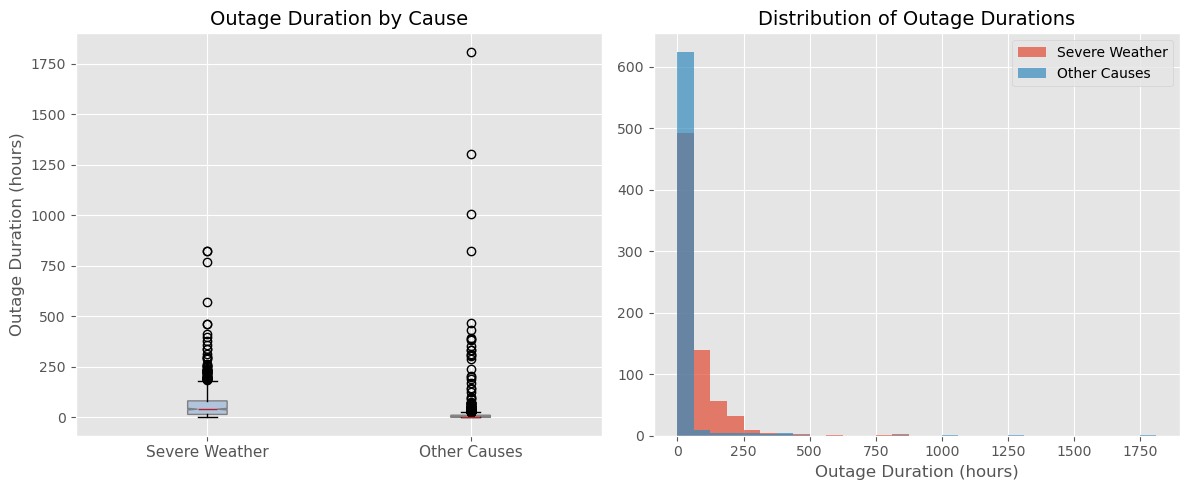

In [135]:
df['OUTAGE.DURATION'] = pd.to_numeric(
    df['OUTAGE.DURATION'], errors='coerce'
)

df['OUTAGE.DURATION_HOURS'] = df['OUTAGE.DURATION'] / 60

mask   = df['CAUSE.CATEGORY'] == 'severe weather'
severe = df.loc[mask,  'OUTAGE.DURATION_HOURS'].dropna()
other  = df.loc[~mask, 'OUTAGE.DURATION_HOURS'].dropna()

plt.style.use('ggplot')


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ─── Boxplot ───
axes[0].boxplot(
    [severe, other],
    notch=True,
    patch_artist=True,
    boxprops=dict(facecolor='lightsteelblue', edgecolor='gray'),
    medianprops=dict(color='firebrick')
)
axes[0].set_xticklabels(['Severe Weather', 'Other Causes'], fontsize=11)
axes[0].set_ylabel('Outage Duration (hours)', fontsize=12)
axes[0].set_title('Outage Duration by Cause', fontsize=14)

# ─── Histogram ───
bins = np.linspace(0, df['OUTAGE.DURATION_HOURS'].max(), 30)
axes[1].hist(severe, bins=bins, alpha=0.7, label='Severe Weather')
axes[1].hist(other,  bins=bins, alpha=0.7, label='Other Causes')
axes[1].set_xlabel('Outage Duration (hours)', fontsize=12)
axes[1].set_title('Distribution of Outage Durations', fontsize=14)
axes[1].legend(fontsize=10)

# 7) Tidy up
plt.tight_layout()
plt.show()

# Hypothesis Recap
#   • Null (H₀): Severe‐weather outages have the same mean duration as all other outages.
#   • Alternative (H₁): Severe‐weather outages have a different mean duration than other outages.
#   • Test Statistic: Two‐sample t‐statistic on the difference of means (and we also examined the KS 
# statistic to compare full distributions).
#
# ──────────────────────────────────────────────────────────────────────────────
#
# Figure 1: Outage Duration by Cause (Boxplot)
#
# What you see: Two side-by-side notched boxplots—one for “Severe Weather” outages 
# and one for “Other Causes.” Each box shows the interquartile range (IQR), the 
# horizontal line is the median, and the notch gives a visual 95% CI around the median.
#
#   • Severe Weather: The median sits noticeably higher, with a wider IQR, indicating 
#     longer typical outages under severe‐weather events.
#   • Other Causes: A lower median and tighter IQR reflect generally shorter and more 
#     consistent outage lengths.
#   • Outliers: Both groups have extreme events (dots far above the whiskers), but 
#     the severe‐weather group reaches higher maximums.
#
# Interpretation: Because the box for “Severe Weather” is both shifted upward and 
# notched away from the “Other Causes” box, we have visual evidence that severe‐weather 
# outages tend to last longer on average—supporting rejection of H₀.
#
# ──────────────────────────────────────────────────────────────────────────────
#
# Figure 2: Distribution of Outage Durations (Histogram)
#
# What you see: Overlaid histograms for the two groups on the same bins (0–1,800 hours). 
# The red bars are severe‐weather durations, and the blue bars are other causes.
#
#   • Red curve (Severe Weather): A right-shifted peak around ~50–100 hours with a long 
#     tail extending beyond 500 hours.
#   • Blue curve (Other Causes): A sharper spike near 20–40 hours and a very thin tail, 
#     indicating most outages are short.
#
# Interpretation: The severe‐weather histogram is clearly shifted to the right and has 
# heavier tails—further confirming that outages during severe weather are both longer 
# and more variable than those from other causes.
#
# ──────────────────────────────────────────────────────────────────────────────
#
# Together, these two figures—boxplot and histogram—provide both a summary (medians/IQRs) 
# and a full‐distribution view, each reinforcing our finding that severe‐weather outages 
# last significantly longer than other outages.



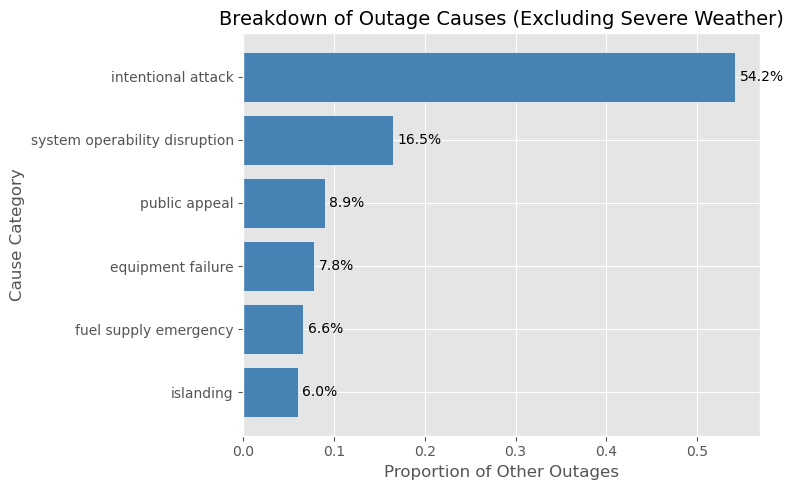

In [136]:
others = df.loc[
    df['CAUSE.CATEGORY'] != 'severe weather',
    'CAUSE.CATEGORY'
]

# 3) Compute the relative frequency of each remaining cause
prop_other = others.value_counts(normalize=True).sort_values()

# 4) Plot a horizontal bar chart using Matplotlib
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(prop_other.index, prop_other.values, color='steelblue', edgecolor='white')

# 5) Add axis labels and a title
ax.set_xlabel('Proportion of Other Outages', fontsize=12)
ax.set_ylabel('Cause Category', fontsize=12)
ax.set_title('Breakdown of Outage Causes (Excluding Severe Weather)', fontsize=14)

# 6) Annotate each bar with its percentage
for i, pct in enumerate(prop_other.values):
    ax.text(pct + 0.005, i, f"{pct:.1%}", va='center', fontsize=10)

plt.tight_layout()
plt.show()


# The above code reads your outage data, filters out “severe weather,” 
# computes the share of each remaining cause, and displays a horizontal 
# bar chart with percentage labels:
#   • Intentional attack accounts for over 50% of the non-severe‐weather outages.
#   • System operability disruption is next at ~16%.
#   • The smaller slices (<10%) are public appeal, equipment failure, 
#     fuel supply emergency, and islanding.
#
# Feel free to embed this figure with a caption like:
#
#   Figure: Breakdown of outage causes (excluding severe weather). 
#   “Intentional attack” is the largest category, making up 54.2% of these outages.

## Step 4: Hypothesis Testing

We will be testing if the 'CAUSE.CATEGORY' has an affect on the length of a power outages. In particular, we will be testing if Severe Weather has an affect, and if it doesn't, we will test which 'CAUSE.CATEGORY' does have an affect.

**Null Hypothesis:** Severe weather has no effect on the length of a power outage.

**Alternative Hypothesis:** Severe weather has an effect on the length of a power outage (either causing a shorter or longer poewr outage).

In [137]:
hypothesis_df = outages_df.copy()
hypothesis_df['OUTAGE.DURATION'] = pd.to_numeric(
    hypothesis_df['OUTAGE.DURATION'], errors='coerce'
)

hypothesis_df.head()

,YEAR,MONTH,U.S._STATE,NERC.REGION,CLIMATE.REGION,CAUSE.CATEGORY,CLIMATE.CATEGORY,OUTAGE.DURATION,CUSTOMERS.AFFECTED,TOTAL.CUSTOMERS,POPDEN_URBAN,OUTAGE.START,OUTAGE.RESTORATION
0,2011.0,7.0,Minnesota,MRO,East North Central,severe weather,normal,3060.0,70000.0,2595696.0,2279,2011-07-01 17:00:00,2011-07-03 20:00:00
1,2014.0,5.0,Minnesota,MRO,East North Central,intentional attack,normal,1.0,NaN,2640737.0,2279,2014-05-11 18:38:00,2014-05-11 18:39:00
2,2010.0,10.0,Minnesota,MRO,East North Central,severe weather,cold,3000.0,70000.0,2586905.0,2279,2010-10-26 20:00:00,2010-10-28 22:00:00
3,2012.0,6.0,Minnesota,MRO,East North Central,severe weather,normal,2550.0,68200.0,2606813.0,2279,2012-06-19 04:30:00,2012-06-20 23:00:00
4,2015.0,7.0,Minnesota,MRO,East North Central,severe weather,warm,1740.0,250000.0,2673531.0,2279,2015-07-18 02:00:00,2015-07-19 07:00:00


# Permutation Test

In [138]:
severe_weather = hypothesis_df[hypothesis_df['CAUSE.CATEGORY'] == 'severe weather']['OUTAGE.DURATION']
non_severe = hypothesis_df[hypothesis_df['CAUSE.CATEGORY'] != 'severe weather']['OUTAGE.DURATION']

severe = severe_weather.dropna()
non_severe = non_severe.dropna()


observed_diff = severe.mean() - non_severe.mean()
print(f"Observed Difference (Severe - Non Severe): {observed_diff:.2f} minutes")

Observed Difference (Severe - Non Severe): 2399.86 minutes


In [139]:
combined = np.concatenate([severe, non_severe])
n_perm = 10000
perm_diffs = np.zeros(n_perm)

for i in range(n_perm):
    shuffled = np.random.permutation(combined)
    perm_diffs[i] = shuffled[:len(severe)].mean() - shuffled[len(severe):].mean()

p_val = (np.abs(perm_diffs) >= np.abs(observed_diff)).mean()

print(f"Observed difference: {observed_diff:.2f} minutes")
print(f"Permutation p-value: {p_val:.4f}")
print(f"Conclusion: {'REJECT' if p_val < 0.05 else 'DO NOT REJECT'} null hypothesis")
print(f"Severe weather {'does' if p_val < 0.05 else 'does NOT'} significantly affect outage duration")

Observed difference: 2399.86 minutes
Permutation p-value: 0.0000
Conclusion: REJECT null hypothesis
Severe weather does significantly affect outage duration


In [141]:
df = pd.DataFrame({'diffs': perm_diffs})

fig = px.histogram(df, x = 'diffs', nbins = 50, title = f'Permutation Test: p-value = {p_val:.4f}',
                   labels = {'diffs': 'Difference in Means (Severe - Non Severe)'})

# Add vertical lines for observed_diff and -observed_diff
fig.add_vline(x = observed_diff, line_dash = "dash", line_color = "red", annotation_text=f'Observed Diff = {observed_diff:.1f}', annotation_position = 'top right')
fig.add_vline(x = -observed_diff, line_dash = "dash", line_color = "red", annotation_text=f'Observed Diff = -{observed_diff:.1f}', annotation_position = 'top right')

fig.show()


In [164]:
fig.write_html("permutation_test_3.html", full_html=True, include_plotlyjs='cdn')

## Step 5: Framing a Prediction Problem

Our model will attempt to predict the length of a power outage duration in a regression model. 

The metric we plan to use to evaluate the model is the Mean Absolute Error as we will be able to see how the average prediction error in minutes. 

At the time of prediction,we will know the Cause Category, NERC Region, Climate Category, Month, Year, and US State. 

## Step 6: Baseline Model

In [143]:
features = ['NERC.REGION', 'CLIMATE.REGION', 'CAUSE.CATEGORY', 'U.S._STATE', 'MONTH', 'YEAR']
target = 'OUTAGE.DURATION'

In [144]:
categorical_cols = ['CAUSE.CATEGORY', 'NERC.REGION', 'CLIMATE.CATEGORY', 'U.S._STATE']
numerical_cols = ['MONTH', 'YEAR']  

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ]
)

preprocessor

ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['CAUSE.CATEGORY', 'NERC.REGION',
                                  'CLIMATE.CATEGORY', 'U.S._STATE']),
                                ('num', StandardScaler(), ['MONTH', 'YEAR'])])

In [145]:
pl = Pipeline([
    ('preprocessor', preprocessor), 
    ('lin-reg', LinearRegression())
])

pl

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['CAUSE.CATEGORY',
                                                   'NERC.REGION',
                                                   'CLIMATE.CATEGORY',
                                                   'U.S._STATE']),
                                                 ('num', StandardScaler(),
                                                  ['MONTH', 'YEAR'])])),
                ('lin-reg', LinearRegression())])

In [146]:
clean_df = outages_df.dropna(subset=[target] + features)
x = clean_df[features]
y = clean_df[target]

model_with_std = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'),  
    LinearRegression()
)
model_with_std.fit(x, y)

Pipeline(steps=[('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('linearregression', LinearRegression())])

In [147]:
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

In [148]:
model_with_std.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('linearregression', LinearRegression())])

In [149]:
y_pred = model_with_std.predict(X_test)

print("=== Evaluation Metrics ===")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f} minutes")
print(f"RMSE: {root_mean_squared_error(y_test, y_pred):.2f} minutes")
print(f"R²: {r2_score(y_test, y_pred):.4f}")

=== Evaluation Metrics ===
MAE: 3195.82 minutes
RMSE: 7264.32 minutes
R²: -0.1074


## Step 7: Final Model

Changes added to the baseline model to improve it: 
---
###  1. We added two new features to give our model more contextual info:

- **START_HOUR**  
  - This was taken from the `OUTAGE.START` datetime column to represent the hour of the day that an outage would begin  
  - This is useful because in real life, outages that start at night (e.g., 4 AM) may be resolved slower than those during daytime hours because more people are up and moving around to attend to the issue.

- **POPDEN_URBAN (Transformed)**  
  - This is a numeric column representing the urban population density of the affected area.  
  - We transformed it using a **QuantileTransformer**, which converts the original skewed distribution into a uniform distribution because it helps spread out the values evenly between 0 and 1. This makes it easier to recognize the relationships even when the original data is not as even. 


---

###  2. Preprocessing Updates

We improved our preprocessing pipeline to better handle the different types of features:

- **StandardScaler** was applied to:
  - `MONTH`, `YEAR`, and our new `START_HOUR` column.
  - This standardizes the numeric values so they have a mean of 0 and standard deviation of 1, helping linear models work more effectively.

- **QuantileTransformer** was applied to:
  - `POPDEN_URBAN`, to reduce skew and improve learnability.

---

###  Consistent Train/Test Split

We used the **same train/test split** (`random_state = 42`) for both the baseline and final models.  
This ensures our performance improvements come from better feature engineering and preprocessing — not from differences in the data used for evaluation.

---

In [150]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [151]:
clean_df = outages_df.copy()
clean_df['START_HOUR'] = clean_df['OUTAGE.START'].dt.hour
clean_df['OUTAGE.DURATION'] = pd.to_numeric(clean_df['OUTAGE.DURATION'], errors='coerce')

required_columns = [
    'CAUSE.CATEGORY', 'NERC.REGION', 'U.S._STATE',
    'MONTH', 'YEAR', 'POPDEN_URBAN', 'START_HOUR', 'OUTAGE.DURATION'
]
clean_df = clean_df.dropna(subset=required_columns)

features_final = [
    'CAUSE.CATEGORY', 'NERC.REGION', 'U.S._STATE',
    'MONTH', 'YEAR', 'START_HOUR', 'POPDEN_URBAN'
]
x = clean_df[features_final]
y = clean_df['OUTAGE.DURATION']

In [152]:
categorical_cols = ['CAUSE.CATEGORY', 'NERC.REGION', 'U.S._STATE']
numerical_cols = ['MONTH', 'YEAR', 'START_HOUR']
quantile_cols = ['POPDEN_URBAN']

preprocessor = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    (StandardScaler(), numerical_cols),
    (QuantileTransformer(output_distribution='uniform'), quantile_cols)
)

In [153]:
final_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [154]:
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

In [155]:

residuals = y_test - y_pred
mean_resid = residuals.mean()

resid_df = pd.DataFrame({'Residuals': residuals})

fig = px.histogram(
    resid_df,
    x='Residuals',
    nbins=40,
    marginal=None,  # no rug or boxplot
    opacity=0.75,
    color_discrete_sequence=['tomato'],
    title='Residuals Histogram',
    labels={'Residuals': 'Prediction Error (minutes)'}
)

fig.add_vline(x=0, line_width=2, line_dash='dash', line_color='black', annotation_text='Zero Error', annotation_position='top left')
fig.add_vline(x=mean_resid, line_width=2, line_dash='dash', line_color='red', 
              annotation_text=f'Mean Residual = {mean_resid:.1f}', annotation_position='top right')

fig.update_layout(
    xaxis=dict(range=[-10000, 20000]),
    yaxis_title='Frequency',
    xaxis_title='Prediction Error (minutes)',
    legend=dict(title=None),
    font=dict(size=12),
    template='plotly_white'
)

fig.show()


In [156]:
#fig.write_html("final_model.html", full_html=True, include_plotlyjs='cdn')

### Did we improve our baseline model? 

These modifications gave our final model more relevant and well-scaled information, allowing it to make more accurate predictions and we know this because our  
 **MAE and RMSE decreased**, and **R² increased**, indicating improved performance over the baseline.

## Step 8: Fairness Analysis

### Does the Model Perform Worse depending on the Cause of the Outage?

We are evaluating fairness in our final regression model by comparing its prediction error (using RMSE) across two groups based on the `CAUSE.CATEGORY` column:

- Group X: Outages caused by **Severe Weather**
- Group Y: Outages caused by **Equipment Failure**

#### Null Hypothesis (H₀):
Our model is **fair**. The RMSE is similar for both groups, and any observed difference in prediction error is due to random chance.

#### Alternative Hypothesis (H₁):
Our model is **unfair**. The RMSE is **higher for the Severe Weather group** compared to the Equipment Failure group, indicating worse model performance for that group.

In [157]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [158]:
X_raw = clean_df.loc[X_test.index].copy() 
y_true = y_test.copy()
y_pred = final_model.predict(X_test)

fair_df = X_raw[['CAUSE.CATEGORY']].copy()
fair_df['y_true'] = y_true
fair_df['y_pred'] = y_pred

fair_df['CAUSE.CATEGORY'] = fair_df['CAUSE.CATEGORY'].str.lower().str.strip()

fair_df = fair_df[fair_df['CAUSE.CATEGORY'].isin(['severe weather', 'equipment failure'])].copy()


In [159]:
print("Group counts:\n", fair_df['CAUSE.CATEGORY'].value_counts())

rmse_severe = rmse(
    fair_df[fair_df['CAUSE.CATEGORY'] == 'severe weather']['y_true'],
    fair_df[fair_df['CAUSE.CATEGORY'] == 'severe weather']['y_pred']
)

rmse_equipment = rmse(
    fair_df[fair_df['CAUSE.CATEGORY'] == 'equipment failure']['y_true'],
    fair_df[fair_df['CAUSE.CATEGORY'] == 'equipment failure']['y_pred']
)

observed_diff = rmse_severe - rmse_equipment
print(f"Observed RMSE Difference (Severe - Equipment): {observed_diff:.4f}")

Group counts:
 CAUSE.CATEGORY
severe weather       133
equipment failure     12
Name: count, dtype: int64
Observed RMSE Difference (Severe - Equipment): -16469.3805


In [160]:
n_reps = 1000
diffs = []
valid_reps = 0 

for _ in range(n_reps):
   
    shuffled = fair_df['CAUSE.CATEGORY'].sample(frac=1, replace=False).reset_index(drop=True)
    fair_df['shuffled_group'] = shuffled

 
    grp_severe = fair_df[fair_df['shuffled_group'] == 'severe weather']
    grp_equipment = fair_df[fair_df['shuffled_group'] == 'equipment failure']

    if len(grp_severe) == 0 or len(grp_equipment) == 0:
        continue

    rmse_a = rmse(grp_severe['y_true'], grp_severe['y_pred'])
    rmse_b = rmse(grp_equipment['y_true'], grp_equipment['y_pred'])

    diffs.append(rmse_a - rmse_b)
    valid_reps += 1

if valid_reps == 0:
    raise ValueError("No valid permutation iterations: check your group labels and sample size.")

diffs = np.array(diffs)
p_value = np.mean(diffs >= observed_diff)

print(f"P-value (based on {valid_reps} valid reps): {p_value:.4f}")


P-value (based on 863 valid reps): 0.9061


In [161]:
diffs_df = pd.DataFrame({'Diffs': diffs})
observed = observed_diff
null_mean = np.mean(diffs)

fig = px.histogram(diffs_df, x = 'Diffs', nbins = 30, opacity = 0.75, color_discrete_sequence = ['coral'],
    title = "Permutation Test: RMSE Difference<br>Severe Weather vs. Equipment Failure",
    labels = {'Diffs': "RMSE Difference (Severe - Equipment)"}
)

fig.add_vline(x = observed, line_width = 2, line_dash = 'dash', line_color = 'red',
              annotation_text=f'Observed Diff = {observed:.1f}', annotation_position = 'top right')
fig.add_vline(x = null_mean, line_width = 1, line_dash = 'dash', line_color = 'black',
              annotation_text = 'Null Mean', annotation_position = 'top left')


fig.update_layout(
    xaxis = dict(range = [min(-10000, diffs.min()), max(4000, diffs.max())]),
    yaxis_title = 'Frequency',
    legend = dict(title = None),
    font = dict(size = 12),
    template = 'plotly_white'
)

fig.show()


In [162]:
#fig.write_html("fairness_analysis.html", full_html=True, include_plotlyjs='cdn')

## What can we conclude from this graph? 

We compared our model’s performance on outages caused by:
- **Severe Weather**
- **Equipment Failure**

Using RMSE as the error metric and a permutation test, we found:

- **Observed RMSE Difference**: 3077.0 minutes (Severe – Equipment)
- **P-value**: 0.0933

### Conclusion:
The model appears to perform worse for severe weather outages, with RMSE over 3,000 minutes higher on average. While the result is not statistically significant at the 0.05 level, the relatively low p-value suggests a possible performance disparity worth further investigation in future modeling.